In [1]:
import hddm
import numpy as np
import scipy as scp
import os 
import sys
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
# Check network outputs

# Set model
model = "ddm_seq2_no_bias"
# Load a torch_network
torch_model = hddm.network_inspectors.load_torch_mlp(model = model)

# Set some metadata
n_choices = hddm.model_config.model_config[model]['n_choices']
choice_options = hddm.model_config.model_config[model]['choices']
rt_range = (0, 20)
rt_steps = 0.01
theta = hddm.model_config.model_config[model]['default_params']
plot_colors = ['black', 'red', 'green', 'blue']


tanh
tanh
tanh
linear


In [3]:
# Generate data to evaluate net on
rts = np.expand_dims(np.concatenate([np.arange(rt_range[0], rt_range[1], rt_steps) for i in range(n_choices)]), axis = 1) #, np.arange(0,10, 0.01), np.arange(0,10, 0.01)]), axis = 1)
choices = np.concatenate([[c for i in range(int((rt_range[1] - rt_range[0]) / rt_steps))] for c in choice_options])
thetas = np.tile(np.array(theta), reps = (rts.shape[0],1))
my_data = np.column_stack([thetas, rts, choices]).astype(np.float32)
my_data = np.column_stack([my_data, np.exp(torch_model.predict_on_batch(my_data))])

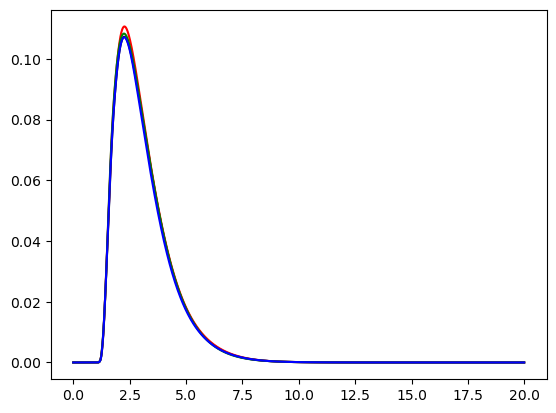

In [4]:
# Plot
for c in choice_options: #  2, 3]:
    plt.plot(my_data[my_data[:, -2] == c, -3], my_data[my_data[:, -2] == c, -1], 
             color = plot_colors[c])  

plt.show()

In [5]:
# Simulate DATA

# Test Regressor
n_samples_per_subject = 1000
n_subjects = 1

data, full_parameter_dict = hddm.simulators.hddm_dataset_generators.simulator_h_c(n_subjects = n_subjects,
                                                                                  n_trials_per_subject = n_samples_per_subject,
                                                                                  model = model,
                                                                                  p_outlier = 0.00,
                                                                                  conditions = None,
                                                                                  depends_on = None,
                                                                                  regression_models = ['a ~ covariate'],
                                                                                  regression_covariates = {'covariate': {'type': 'continuous', 
                                                                                                           'range': (0, 4)}},
                                                                                  group_only_regressors = False,
                                                                                  group_only = None,
                                                                                  fixed_at_default = None) #['z'])


None
{'vl1', 't', 'vl2', 'vh'}
1.1388371060513998
          vh       vl1       vl2         a         t
0    1.17622 -2.146752  0.720742  1.198016  1.648032
1    1.17622 -2.146752  0.720742  1.236851  1.648032
2    1.17622 -2.146752  0.720742  1.198761  1.648032
3    1.17622 -2.146752  0.720742  1.187879  1.648032
4    1.17622 -2.146752  0.720742  1.196553  1.648032
..       ...       ...       ...       ...       ...
995  1.17622 -2.146752  0.720742  1.227021  1.648032
996  1.17622 -2.146752  0.720742  1.223229  1.648032
997  1.17622 -2.146752  0.720742  1.226371  1.648032
998  1.17622 -2.146752  0.720742  1.189645  1.648032
999  1.17622 -2.146752  0.720742  1.194518  1.648032

[1000 rows x 5 columns]


In [6]:
full_parameter_dict

{'vl1': -2.146752484767409,
 'vl1_std': 0.33535160050810114,
 't': 1.6480316460129378,
 't_std': 0.18908691332185157,
 'vl2': 0.7207417763866204,
 'vl2_std': 0.19189453689613267,
 'vh': 1.1762203899654011,
 'vh_std': 0.3970111822674243,
 'a_reg': OrderedDict([('a_Intercept', 1.1388371060513998),
              ('a_covariate', 0.08221967948413328)]),
 'a_reg_std': OrderedDict([('a_Intercept_std', 0.0353909739469888),
              ('a_covariate_std', 0.06872316388199655)]),
 'a_Intercept': 1.1703724761700451,
 'a_covariate': 0.06649852166453608,
 'a_Intercept_std': 0.0353909739469888,
 'a_covariate_std': 0.06872316388199655}

In [7]:
# Define the HDDM model
def id_link(x):
    return x

reg_models = [{'model': 'a ~ covariate',
               'link_func': id_link}]

includes = hddm.model_config.model_config[model]['hddm_include'].copy()
n_samples = 1000
n_burn = 500

hddmnn_torch_reg_model = hddm.HDDMnnRegressor(data,
                                          reg_models,
                                          informative = False,
                                          include = includes,
                                          p_outlier = 0.0,
                                          w_outlier = 0.01,
                                          model = model,
                                          network_type = 'torch_mlp')

hddmnn_torch_model = hddm.HDDMnn(data,
                                informative = False,
                                include = includes,
                                p_outlier = 0.0,
                                w_outlier = 0.1,
                                model = model,
                                network_type = 'torch_mlp')

Setting priors uninformative (LANs only work with uninformative priors for now)
tanh
tanh
tanh
linear
def custom_likelihood_reg(value, vh, vl1, vl2, a, t, reg_outcomes, p_outlier=0, w_outlier=0.1, **kwargs):
    params = locals()
    size = int(value.shape[0])
    data = np.zeros(((size, 7)), dtype=np.float32)
    data[:, 5:] = np.stack([np.absolute(value["rt"]).astype(np.float32), value["response"].astype(np.float32)], axis=1)
    cnt=0
    for tmp_str in ['vh', 'vl1', 'vl2', 'a', 't']:
        if tmp_str in reg_outcomes:
            data[:, cnt] = params[tmp_str].loc[value["rt"].index].values
            if (data[:, cnt].min() < [-2.5, -2.5, -2.5, 0.3, 0.0][cnt]) or (data[:, cnt].max() > [2.5, 2.5, 2.5, 2.0, 2.0][cnt]):
                print("boundary violation of regressor part")
                return -np.inf
        else:
            data[:, cnt] = params[tmp_str]
        cnt += 1
    return hddm.wfpt.wiener_like_multi_nn_mlp(data, p_outlier=p_outlier, w_outlier=w_outlier, network

In [8]:
# Run sampler
hddmnn_torch_reg_model.sample(n_samples,
                              burn = n_burn)

 [-----------------100%-----------------] 1000 of 1000 complete in 94.0 sec

In [9]:
hddmnn_torch_reg_model.get_traces().mean()

vh             1.236712
vl1           -2.296183
vl2            0.743478
t              1.642208
a_Intercept    1.152930
a_covariate    0.138271
dtype: float64

In [10]:
# Run sampler
hddmnn_torch_model.sample(n_samples,
                          burn = n_burn)

 [-----------------100%-----------------] 1000 of 1000 complete in 62.5 sec

In [11]:
hddmnn_torch_model.get_traces()

,vh,vl1,vl2,a,t
0,1.150886,-2.398529,0.767295,1.230939,1.613892
1,1.143730,-2.422220,0.740074,1.223653,1.607099
2,1.283792,-2.236433,0.751396,1.193550,1.676851
3,1.146828,-2.174738,0.775661,1.191323,1.642835
4,1.130848,-2.100832,0.757549,1.193402,1.656801
...,...,...,...,...,...
495,1.246566,-2.186271,0.742285,1.215208,1.651308
496,1.246304,-2.176393,0.722752,1.235341,1.627326
497,1.276372,-2.265718,0.751307,1.204289,1.631459
498,1.176364,-2.250745,0.713224,1.197258,1.673332


In [13]:
# Generate Data from Posterior Predictive
post_pred_torchnn = hddm.utils.post_pred_gen(hddmnn_torch_model,
                                             samples = 100,
                                             progress_bar = False)
#post_pred_torchnn_reg = hddm.utils.post_pred_gen(hddmnn_torch_reg_model, samples = 100, progress_bar = False)

Sampling...


In [17]:
mgd = post_pred_torchnn.groupby('sample')

In [22]:
for idx, sample in mgd:
    print(sample.shape[0])

1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


In [14]:
post_pred_torchnn_reg = hddm.utils.post_pred_gen(hddmnn_torch_reg_model,
                                                 samples = 100,
                                                 progress_bar = False)

Sampling...


In [36]:
def plot_posterior_predictive(model = None, sim_model = None, 
                              samples = None, bin_size = 0.05, 
                              save = False, save_file_name = None,
                              title = 'no_title',
                              use_hddm = True,
                              x_lims = (0, 10),
                              post_pred_alpha = 0.1,
                              mode = 'standard', # allows 'standard' (show uncertainty) and 'average' (single histogram for average posterior)
                              post_pred_groupby = None,
                              ):
    
    cl_dct = {-1:'orange',
              0: 'black',
              1: 'red',
              2: 'green',
              3: 'blue'}
    
    # Get posterior predictive samples
    out = hddm.utils.post_pred_gen(model, 
                                   samples = samples, 
                                   groupby = post_pred_groupby, 
                                   append_data = False)

    # Get  posterior samples  and plot those
    if mode == 'standard':
        for s_idx, sample in out.groupby('sample'):
            for c in hddm.model_config.model_config[sim_model]['choices']:
                weights_pp = np.tile((1 / bin_size) / sample.shape[0], reps = sample['rt'][sample['response'] == c].shape[0])
                
                plt.hist(sample['rt'][sample['response'] == c], 
                         density = False,
                         weights = weights_pp,
                         bins = np.arange(x_lims[0], x_lims[1], bin_size),
                         histtype = 'step',
                         color = cl_dct[c],
                         alpha = post_pred_alpha)
    
    elif mode == 'average':
        for c in hddm.model_config.model_config[sim_model]['choices']:
                weights_pp = np.tile((1 / bin_size) / out.shape[0], reps = out['rt'][out['response'] == c].shape[0])
                
                plt.hist(out['rt'][out['response'] == c], 
                         density = False,
                         weights = weights_pp,
                         bins = np.arange(x_lims[0], x_lims[1], bin_size),
                         histtype = 'step',
                         color = cl_dct[c],
                         linestyle = '--'
                         alpha = 1)
    
    else:
        return 'mode argument not recognized as valid (choose either [standard] or [average])'

    # Add model data
    for c in hddm.model_config.model_config[sim_model]['choices']:
        weights = np.tile((1 / bin_size) / model.data['rt'].shape[0], 
                        reps = model.data['rt'][model.data['response'] == c].shape[0])
        
        plt.hist(model.data['rt'][model.data['response'] == c], 
                 density = False,
                 weights = weights,
                 bins = np.arange(x_lims[0], x_lims[1], bin_size),
                 histtype = 'step',
                 linestyle = '-',
                 color = cl_dct[c])
        
        plt.title(title)
    
    if save:
        plt.savefig(save_file_name + ".png", 
                    format = "png")
    plt.show()
    return 
    

 [--------------------------------------------------------------------------400%--------------------------------------------------------------------------] 4 of 1 complete in 10.8 sec

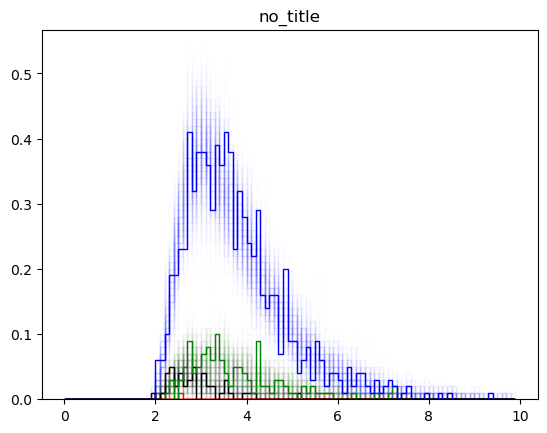

In [34]:
plot_posterior_predictive(model = hddmnn_torch_model,
                         sim_model = model,
                         samples = 100,
                         bin_size = 0.1,
                         post_pred_alpha = 0.01)

 [--------------------------------------------------------------------------400%--------------------------------------------------------------------------] 4 of 1 complete in 12.1 sec

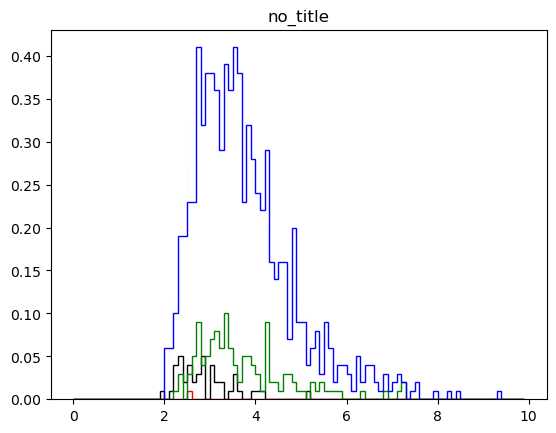

In [37]:
plot_posterior_predictive(model = hddmnn_torch_model,
                         sim_model = model,
                         samples = 100,
                         bin_size = 0.1,
                         post_pred_alpha = 0.01,
                         mode = 'average')

In [40]:
# thetas = np.tile(hddm.model_config.model_config[model]['default_params'], reps = (1000, 1))
# thetas[:, 4] = np.linspace(0.01, 1.99, 1000)

# out = hddm.simulators.basic_simulator.simulator(model = model, 
#                                 theta = thetas,
#                                 n_samples = 1)